<a href="https://colab.research.google.com/github/SaurabhMapari/Electricity-Consumption-Timeseries-Forecasting/blob/main/ElctForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:

# Assuming the CSV file is located in the same directory as your Python script
df = pd.read_csv('electricityConsumptionAndProductioction.csv')

# Print the DataFrame
print(df)


                  DateTime  Consumption  Production  Nuclear  Wind  \
0      2019-01-01 00:00:00         6352        6527     1395    79   
1      2019-01-01 01:00:00         6116        5701     1393    96   
2      2019-01-01 02:00:00         5873        5676     1393   142   
3      2019-01-01 03:00:00         5682        5603     1397   191   
4      2019-01-01 04:00:00         5557        5454     1393   159   
...                    ...          ...         ...      ...   ...   
36767  2023-03-12 19:00:00         6500        6643     1407   111   
36768  2023-03-12 20:00:00         6471        6484     1408    58   
36769  2023-03-12 21:00:00         6194        6413     1406    39   
36770  2023-03-12 22:00:00         5708        6217     1406     8   
36771  2023-03-12 23:00:00         5409        5900     1403     0   

       Hydroelectric  Oil and Gas  Coal  Solar  Biomass  
0               1383         1896  1744      0       30  
1               1112         1429  1641    

In [ ]:
print(df.columns)

Index(['DateTime', 'Consumption', 'Production', 'Nuclear', 'Wind',
       'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'],
      dtype='object')


In [ ]:

# Calculate the minimum and maximum dates
min_date = df['DateTime'].min()
max_date = df['DateTime'].max()

# Print the range
print(f"Date range: {min_date} to {max_date}")

Date range: 2019-01-01 00:00:00 to 2023-03-12 23:00:00


In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Create DataFrames for each year
df_2019 = df[df['DateTime'].dt.year == 2019]
df_2020 = df[df['DateTime'].dt.year == 2020]
df_2021 = df[df['DateTime'].dt.year == 2021]

# Create a DataFrame for the rest of the years
df_rest = df[~df['DateTime'].dt.year.isin([2019, 2020, 2021])]

# Print the first few rows to verify
print("2019 DataFrame:")
print(df_2019.head())
print("\n2020 DataFrame:")
print(df_2020.head())
print("\n2021 DataFrame:")
print(df_2021.head())
print("\nRest of the years DataFrame:")
print(df_rest.tail())


2019 DataFrame:
             DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0 2019-01-01 00:00:00         6352        6527     1395    79           1383   
1 2019-01-01 01:00:00         6116        5701     1393    96           1112   
2 2019-01-01 02:00:00         5873        5676     1393   142           1030   
3 2019-01-01 03:00:00         5682        5603     1397   191            972   
4 2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  
0         1896  1744      0       30  
1         1429  1641      0       30  
2         1465  1616      0       30  
3         1455  1558      0       30  
4         1454  1458      0       30  

2020 DataFrame:
                DateTime  Consumption  Production  Nuclear  Wind  \
8761 2020-01-01 00:00:00         6418        5974     1422  1146   
8762 2020-01-01 01:00:00         6183        5863     1424  1228   
8763 2020-01-01 02:00:00         6183        586

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36772 entries, 0 to 36771
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       36772 non-null  datetime64[ns]
 1   Consumption    36772 non-null  int64         
 2   Production     36772 non-null  int64         
 3   Nuclear        36772 non-null  int64         
 4   Wind           36772 non-null  int64         
 5   Hydroelectric  36772 non-null  int64         
 6   Oil and Gas    36772 non-null  int64         
 7   Coal           36772 non-null  int64         
 8   Solar          36772 non-null  int64         
 9   Biomass        36772 non-null  int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 2.8 MB


In [ ]:
# set the DateTime as the index
df = df.set_index("DateTime")
df.index = pd.to_datetime(df.index)

In [ ]:
df.drop(['Production', 'Nuclear', 'Wind','Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'], axis=1, inplace=True)

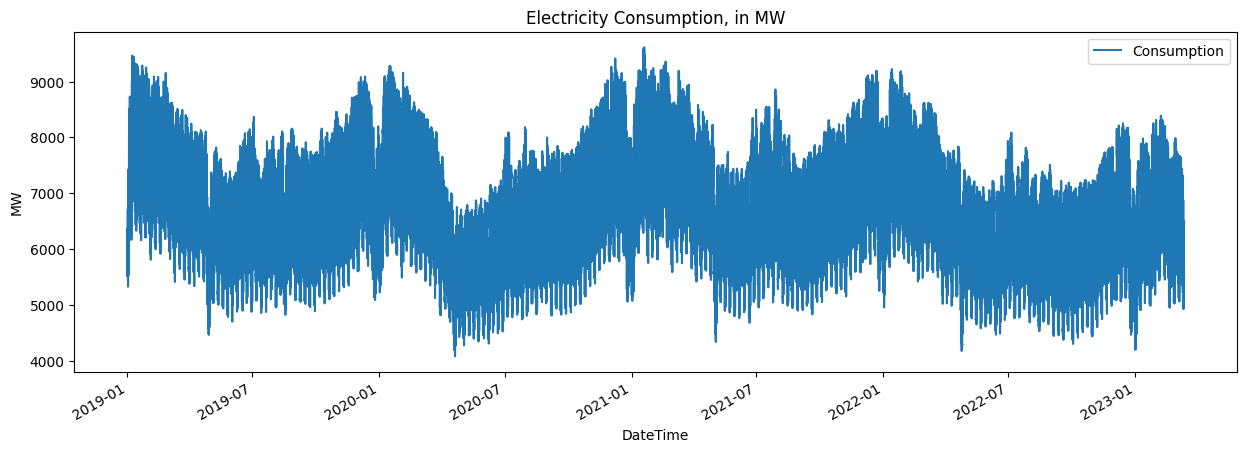

In [ ]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

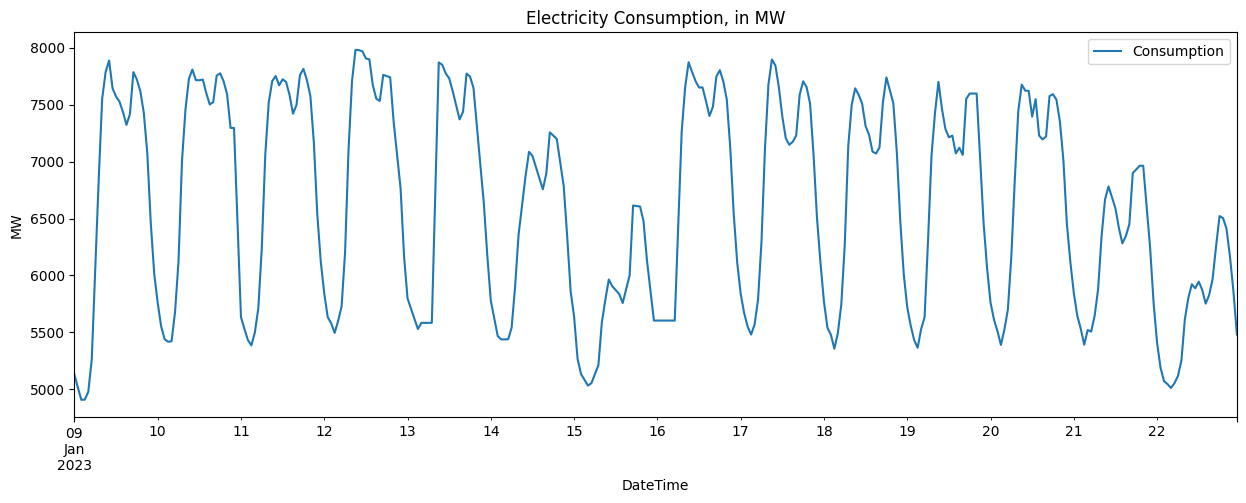

In [ ]:
df["2023-01-09 00:00:00" : "2023-01-22 23:59:59"][["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

In [ ]:
# method for adding time features by the time index
def createTimeFeatures(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear


# apply the method to the existing dataframe
createTimeFeatures(df)

df.head()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1


In [ ]:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

# Define standard Romanian holidays
class RomanianHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year\'s Day', month=1, day=1),
        Holiday('Day after New Year\'s Day', month=1, day=2),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Children\'s Day', month=6, day=1),
        Holiday('St. Mary\'s Day', month=8, day=15),
        Holiday('St. Andrew\'s Day', month=11, day=30),
        Holiday('National Day', month=12, day=1),
        Holiday('Christmas Day', month=12, day=25),
        Holiday('Second Day of Christmas', month=12, day=26)
    ]

# Create an instance of the holiday calendar and get the holidays
cal = RomanianHolidayCalendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())

# Add a 'holiday' column to the DataFrame
df['holiday'] = df.index.normalize().isin(holidays)


# Add a 'is_weekend' column to the DataFrame
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Show the first few rows of the updated DataFrame
df.head()


,Consumption,hour,day_of_week,quarter,month,year,day_of_year,holiday,is_weekend
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1,True,False
2019-01-01 01:00:00,6116,1,1,1,1,2019,1,True,False
2019-01-01 02:00:00,5873,2,1,1,1,2019,1,True,False
2019-01-01 03:00:00,5682,3,1,1,1,2019,1,True,False
2019-01-01 04:00:00,5557,4,1,1,1,2019,1,True,False


**Train - Test Split**

cutOffDate 2022-03-13 01:00:00
train size: 28013 and test 8759


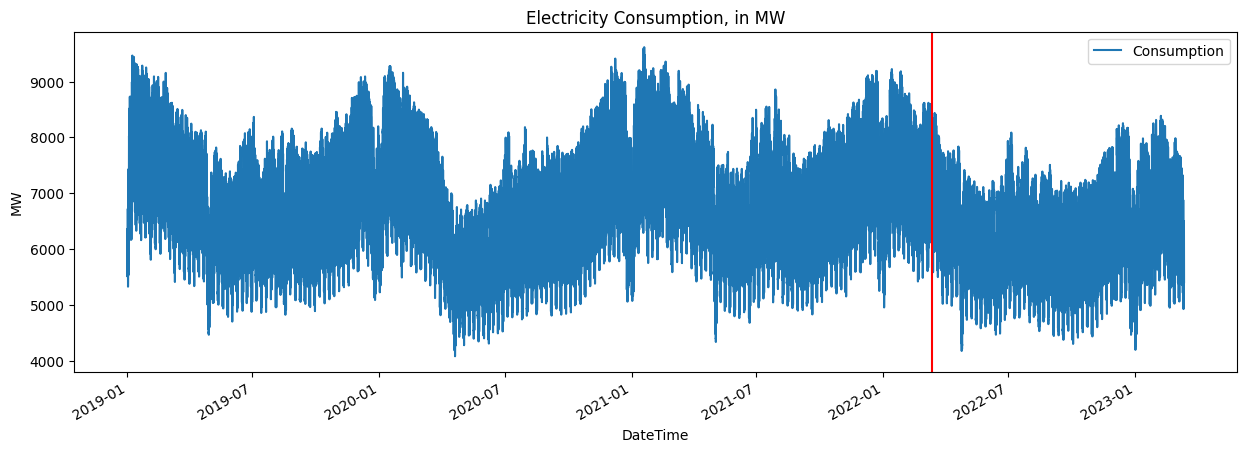

In [ ]:
cutOffDate = df.index[-365 * 24]
print(f"cutOffDate {cutOffDate}")

train = df.loc[df.index <= cutOffDate]
test = df.loc[df.index > cutOffDate]

print(f"train size: {len(train)} and test {len(test)}")

df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.axvline(x=cutOffDate, color='r')
plt.show()

In [ ]:
def meanAbsolutErrorAaPercentage(real, predicted):
    real = np.array(real)
    predicted = np.array(predicted)

    return np.mean(np.abs((real - predicted) / real)) * 100

In [ ]:
print(df.columns)

Index(['Consumption', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year', 'holiday', 'is_weekend'],
      dtype='object')


In [ ]:
FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year', 'holiday', 'is_weekend']
# FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year', 'is_weekend']
TARGET = "Consumption"

In [ ]:
prophetTrain = train.reset_index()
prophetTrain.drop(FEATURES, axis=1, inplace=True)
prophetTrain.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTrain.tail()

,ds,y
28008,2022-03-12 21:00:00,7458
28009,2022-03-12 22:00:00,6912
28010,2022-03-12 23:00:00,6377
28011,2022-03-13 00:00:00,6119
28012,2022-03-13 01:00:00,5864


In [ ]:
prophetTest = test.reset_index()
prophetTest.drop(FEATURES, axis=1, inplace=True)
prophetTest.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTest.tail()

,ds,y
8754,2023-03-12 19:00:00,6500
8755,2023-03-12 20:00:00,6471
8756,2023-03-12 21:00:00,6194
8757,2023-03-12 22:00:00,5708
8758,2023-03-12 23:00:00,5409


**Model Training without features**

In [ ]:
prophetModel = Prophet()
prophetModel.fit(prophetTrain)

prophetPrediction = prophetModel.predict(prophetTest)

yRealProphet = test["Consumption"]
yPredictedProphet = prophetPrediction["yhat"]

print(f"Prophet percentage error with no features: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/7fnhsvc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/vzs2alsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61153', 'data', 'file=/tmp/tmpjkr0oth7/7fnhsvc6.json', 'init=/tmp/tmpjkr0oth7/vzs2alsf.json', 'output', 'file=/tmp/tmpjkr0oth7/prophet_modelmsbd80d2/prophet_model-20231229162033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet percentage error with no features: 5.4776


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmseNoFeatures = sqrt(mean_squared_error(yRealProphet, yPredictedProphet))
print('RMSE no features:')
print(rmseNoFeatures)
print(f"Prophet percentage error with no features: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")
# Ensure yRealProphet and yPredictedProphet are numeric
yRealProphet_numeric = pd.to_numeric(yRealProphet, errors='coerce')
yPredictedProphet_numeric = pd.to_numeric(yPredictedProphet, errors='coerce')
r2 = r2_score(yRealProphet_numeric, yPredictedProphet_numeric)
print(f"R² Score: {r2}")

RMSE no features:
435.3318614441886
Prophet percentage error with no features: 5.4776
R² Score: 0.7590631020566446


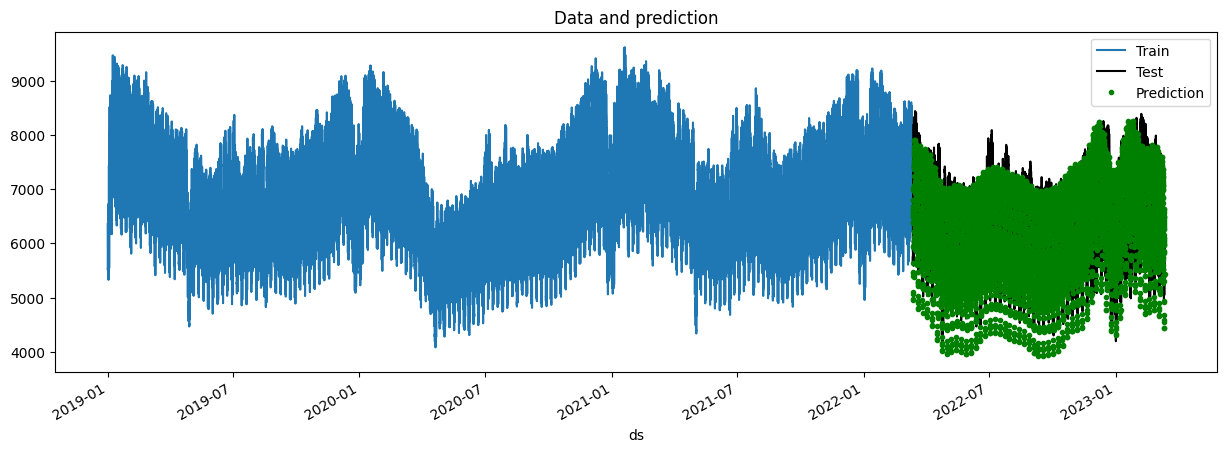

In [ ]:
ax = train[TARGET].plot(figsize=(15,5), label='Train')
test[TARGET].plot(ax=ax, label='Test', style="k-")
prophetPrediction.set_index("ds")["yhat"].plot(ax=ax, style=".", color="g", label='Prediction')
ax.legend()
ax.set_title("Data and prediction")
plt.show()

**Model Training with features**

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize the Prophet model
prophetModel = Prophet()

# Add additional regressors
for feature in FEATURES:
    prophetModel.add_regressor(feature)

# Prepare training data with additional regressors
prophetTrain = train.reset_index().rename(columns={"DateTime": "ds", TARGET: "y"})

# Fit the model
prophetModel.fit(prophetTrain)

prophetTest = test.reset_index()
prophetTest.rename(columns={"DateTime": "ds", TARGET: "y"}, inplace=True)

# Use the model to make a forecast
prophetPrediction = prophetModel.predict(prophetTest)

# Calculate error
yRealProphet = test[TARGET]
yPredictedProphet = prophetPrediction["yhat"]
print(f"Prophet percentage error: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/w0r8ul5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/jtsdy_2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17900', 'data', 'file=/tmp/tmpjkr0oth7/w0r8ul5r.json', 'init=/tmp/tmpjkr0oth7/jtsdy_2r.json', 'output', 'file=/tmp/tmpjkr0oth7/prophet_modelcqgqwyg8/prophet_model-20231229162113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet percentage error: 5.2047


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmseFeatures = sqrt(mean_squared_error(yRealProphet, yPredictedProphet))
print('RMSE after considering features:')
print(rmseFeatures)
print(f"Prophet percentage error: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")
# Ensure yRealProphet and yPredictedProphet are numeric
yRealProphet_numeric = pd.to_numeric(yRealProphet, errors='coerce')
yPredictedProphet_numeric = pd.to_numeric(yPredictedProphet, errors='coerce')
r2 = r2_score(yRealProphet_numeric, yPredictedProphet_numeric)
print(f"R² Score: {r2}")

RMSE after considering features:
412.55399288943994
Prophet percentage error: 5.2047
R² Score: 0.7836165721650634


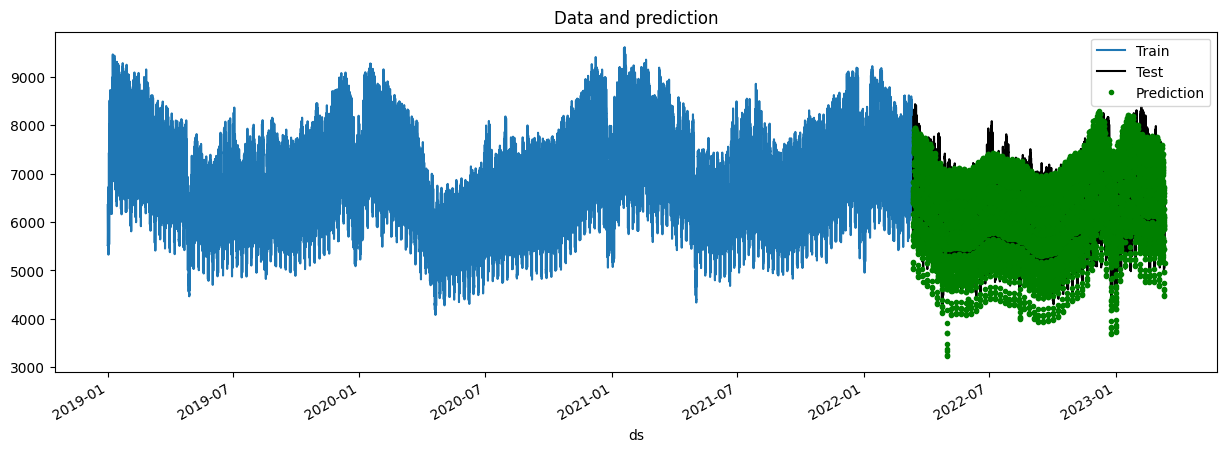

In [ ]:
ax = train[TARGET].plot(figsize=(15,5), label='Train')
test[TARGET].plot(ax=ax, label='Test', style="k-")
prophetPrediction.set_index("ds")["yhat"].plot(ax=ax, style=".", color="g", label='Prediction')
ax.legend()
ax.set_title("Data and prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    non_zero_mask = denominator != 0
    return 100 * np.mean(np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) / denominator[non_zero_mask])

# Ensure yRealProphet and yPredictedProphet are numeric
yRealProphet_numeric = pd.to_numeric(yRealProphet, errors='coerce')
yPredictedProphet_numeric = pd.to_numeric(yPredictedProphet, errors='coerce')

# Calculate the metrics
mae = mean_absolute_error(yRealProphet_numeric, yPredictedProphet_numeric)
mse = mean_squared_error(yRealProphet_numeric, yPredictedProphet_numeric)
rmse = np.sqrt(mse)
mape_score = mape(yRealProphet_numeric, yPredictedProphet_numeric)
smape_score = smape(yRealProphet_numeric, yPredictedProphet_numeric)
r2 = r2_score(yRealProphet_numeric, yPredictedProphet_numeric)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape_score}%")
print(f"SMAPE: {smape_score}%")
print(f"R² Score: {r2}")



MAE: 316.2218704226495
MSE: 170200.79704902007
RMSE: 412.55399288943994
MAPE: 5.204733865310336%
SMAPE: 5.130109807802823%
R² Score: 0.7836165721650634


**Model Training with features on whole dataset and predicting for next year**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/c6wawj6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjkr0oth7/mlcnloxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37793', 'data', 'file=/tmp/tmpjkr0oth7/c6wawj6t.json', 'init=/tmp/tmpjkr0oth7/mlcnloxz.json', 'output', 'file=/tmp/tmpjkr0oth7/prophet_modeld0t323w7/prophet_model-20231229164544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


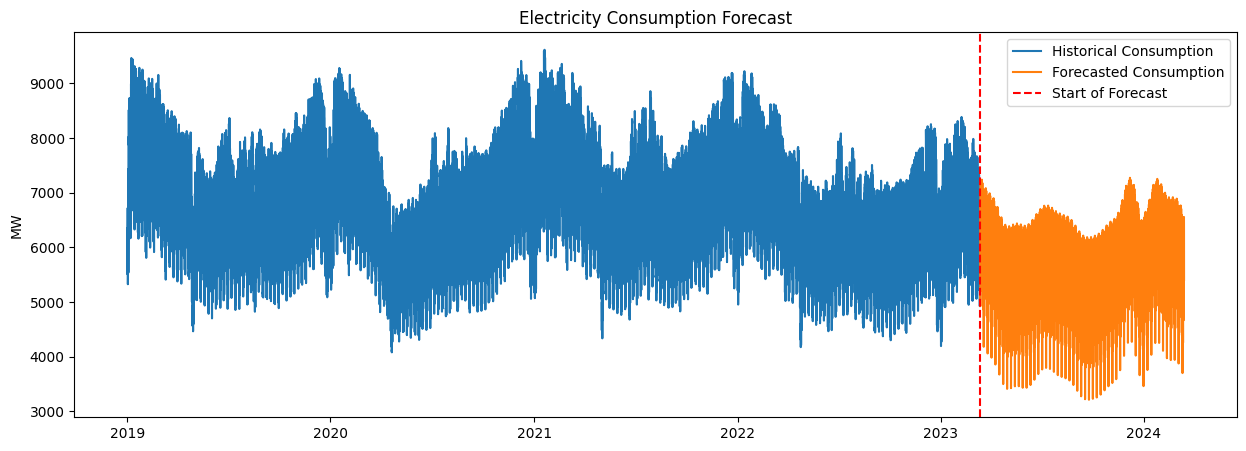

In [ ]:
from prophet import Prophet

# Combine train and test sets
full_data = pd.concat([train, test]).reset_index().rename(columns={"DateTime": "ds", TARGET: "y"})

prophetModel = Prophet()
for feature in FEATURES:
    prophetModel.add_regressor(feature)

# Fit the model with the full dataset
prophetModel.fit(full_data)

# Create a future DataFrame for 1 year beyond the last date in the test set
last_date = test.index[-1]
future_dates = prophetModel.make_future_dataframe(periods=366 * 24, freq='H', include_history=False)

# Add expected values for the additional regressors for the future dates
future_dates['hour'] = future_dates['ds'].dt.hour
future_dates['day_of_week'] = future_dates['ds'].dt.dayofweek
future_dates['quarter'] = future_dates['ds'].dt.quarter
future_dates['month'] = future_dates['ds'].dt.month
future_dates['year'] = future_dates['ds'].dt.year
future_dates['day_of_year'] = future_dates['ds'].dt.dayofyear
future_dates['holiday'] = future_dates['ds'].apply(lambda x: x in holidays)
future_dates['is_weekend'] = future_dates['ds'].dt.dayofweek.isin([5, 6])

# Predict consumption for the future datesa
forecast = prophetModel.predict(future_dates)

# Plot the forecast
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Consumption'], label='Historical Consumption')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Consumption')
plt.axvline(x=last_date, color='r', linestyle='--', label='Start of Forecast')
plt.legend()
plt.title('Electricity Consumption Forecast')
plt.ylabel('MW')
plt.show()


In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-03-13 00:00:00,9367.789237,4772.866520,5751.458803,9367.789237,9367.789237,-4118.002146,-4118.002146,-4118.002146,-748.661206,...,-3834.765765,-3834.765765,-3834.765765,239.927726,239.927726,239.927726,0.0,0.0,0.0,5249.787091
1,2023-03-13 01:00:00,9367.892372,4584.979552,5589.078008,9367.892372,9367.892372,-4303.343719,-4303.343719,-4303.343719,-953.702939,...,-3834.765765,-3834.765765,-3834.765765,238.827821,238.827821,238.827821,0.0,0.0,0.0,5064.548653
2,2023-03-13 02:00:00,9367.995507,4466.166701,5476.279821,9367.995507,9367.995507,-4394.905288,-4394.905288,-4394.905288,-1066.404631,...,-3834.765765,-3834.765765,-3834.765765,237.728455,237.728455,237.728455,0.0,0.0,0.0,4973.090219
3,2023-03-13 03:00:00,9368.098642,4443.263149,5407.945961,9368.098642,9368.098642,-4442.749260,-4442.749260,-4442.749260,-1136.658873,...,-3834.765765,-3834.765765,-3834.765765,236.629649,236.629649,236.629649,0.0,0.0,0.0,4925.349381
4,2023-03-13 04:00:00,9368.201776,4479.313541,5452.099302,9368.201776,9368.201776,-4416.620437,-4416.620437,-4416.620437,-1134.033376,...,-3834.765765,-3834.765765,-3834.765765,235.531425,235.531425,235.531425,0.0,0.0,0.0,4951.581339


In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8779,2024-03-12 19:00:00,10273.210045,3397.345252,9748.861144,7156.668889,13532.832823,-3716.474058,-3716.474058,-3716.474058,747.006126,...,-5442.986457,-5442.986457,-5442.986457,225.677293,225.677293,225.677293,0.0,0.0,0.0,6556.735986
8780,2024-03-12 20:00:00,10273.313180,3351.288720,9891.610897,7156.328763,13533.654012,-3718.486547,-3718.486547,-3718.486547,746.881074,...,-5442.986457,-5442.986457,-5442.986457,224.586114,224.586114,224.586114,0.0,0.0,0.0,6554.826633
8781,2024-03-12 21:00:00,10273.416315,3222.153480,9569.086979,7155.988638,13534.475201,-3964.524486,-3964.524486,-3964.524486,502.389067,...,-5442.986457,-5442.986457,-5442.986457,223.495759,223.495759,223.495759,0.0,0.0,0.0,6308.891828
8782,2024-03-12 22:00:00,10273.519449,2708.312756,9142.818777,7155.648512,13535.296391,-4399.352773,-4399.352773,-4399.352773,68.695496,...,-5442.986457,-5442.986457,-5442.986457,222.406251,222.406251,222.406251,0.0,0.0,0.0,5874.166676
8783,2024-03-12 23:00:00,10273.622584,2353.788151,8666.090330,7155.308387,13536.117580,-4864.605606,-4864.605606,-4864.605606,-395.893565,...,-5442.986457,-5442.986457,-5442.986457,221.317610,221.317610,221.317610,0.0,0.0,0.0,5409.016978


In [ ]:
particular_date = '2023-11-13 14:00:00'
forecasted_value_on_date = forecast[forecast['ds'] == particular_date]['yhat'].iloc[0]
forecasted_value_on_date

6036.960444426719